<a href="https://colab.research.google.com/github/hirokiyamauch/NLP_100knock/blob/%E7%AC%AC9%E7%AB%A0/80_89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# データのダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-08-24 16:18:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  21.3MB/s    in 1.3s    

2022-08-24 16:18:25 (21.3 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
import pandas as pd

data = pd.read_csv("/content/newsCorpora_re.csv", header=None, sep="\t", names=["ID" ,"TITLE" ,"URL" ,"PUBLISHER" ,"CATEGORY" ,"STORY" ,"HOSTNAME" ,"TIMESTAMP"])

print(data)

            ID                                              TITLE  \
0            1  Fed official says weak data caused by weather,...   
1            2  Fed's Charles Plosser sees high bar for change...   
2            3  US open: Stocks fall after Fed official hints ...   
3            4  Fed risks falling 'behind the curve', Charles ...   
4            5  Fed's Plosser: Nasty Weather Has Curbed Job Gr...   
...        ...                                                ...   
422932  422933  Surgeons to remove 4-year-old's rib to rebuild...   
422933  422934  Boy to have surgery on esophagus after battery...   
422934  422935  Child who swallowed battery to have reconstruc...   
422935  422936  Phoenix boy undergoes surgery to repair throat...   
422936  422937  Phoenix boy undergoes surgery to repair throat...   

                                                      URL          PUBLISHER  \
0       http://www.latimes.com/business/money/la-fi-mo...  Los Angeles Times   
1       htt

In [ ]:
from sklearn.model_selection import train_test_split
file_df = data.loc[data['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

train_data, teva_data = train_test_split(file_df, shuffle=True, test_size=0.2, random_state=42, stratify= file_df['CATEGORY'])
valid_data, test_data = train_test_split(teva_data, shuffle=True, test_size=0.5, random_state=42, stratify= teva_data['CATEGORY'])
train_data.to_csv("train.txt", sep="\t")
valid_data.to_csv("valid.txt", sep="\t")
test_data.to_csv("test.txt", sep="\t")

In [ ]:
# 事例数の確認
print('【学習データ】')
print(train_data['CATEGORY'].value_counts())
print('【検証データ】')
print(valid_data['CATEGORY'].value_counts())
print('【評価データ】')
print(test_data['CATEGORY'].value_counts())

【学習データ】
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64
【検証データ】
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64
【評価データ】
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [ ]:
def word_counter(file):
  counter_dic = {}
  for lines in file:
    sentence = lines.split()
    for word in sentence:
        #出現しない言語は新しく保存
        if not word in counter_dic:
            counter_dic[word] = 1
        #出現する場合はcounterを増やす
        else:
           cnt = counter_dic[word]
           cnt += 1
           counter_dic[word] = cnt

  count_list = sorted(counter_dic.items(), reverse=True, key=lambda x : x[1])
  counter_dic.clear()
  counter_dic.update(count_list)

  id_word_dic = make_count_ID(count_list)

  return id_word_dic

#頻出単語順にIDをわりふり
def make_count_ID(count_list):
    id_word_dic = {}
    for i, li in enumerate(count_list):
        if li[1] >= 2:
            id_word_dic[li[0]] = (i+1)
    
    return id_word_dic

df_title = train_data["TITLE"]
id_word_dic = word_counter(df_title) 

In [ ]:
def id_transform(lines, id_word_dic=id_word_dic):
  id_transform_file = []
  sentence = lines.split()
  ids = []
  #一単語ごとにdicで出現頻度が2回以上の場合、IDを付与
  for word in sentence:
        if word in id_word_dic:
            ids.append(int(id_word_dic[word]))
        else:
            ids.append(0)
  id_transform_file = ids
  
  return id_transform_file

81

In [ ]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.data = X
    self.label = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.label)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.data[index]
    label_puts = self.label[index]

    if self.tokenizer:
        inputs = self.tokenizer(text)
        
    return torch.tensor(inputs, dtype=torch.int64), torch.tensor(label_puts, dtype=torch.int64)

In [ ]:
import torch
import torch.nn as nn

class MyRNN(torch.nn.Module):
    # 埋め込み層, 隠れ層, 全結合層の定義 
    def __init__(self, vocab_size, input_size,padding_idx, output_size, hidden_size, device):
        super().__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, input_size, padding_idx=padding_idx)
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)
    
    # 順伝播
    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden() 
        output, h = self.rnn(self.emb(x), hidden)
        output = self.fc(output[:, -1, :])
        return output

    def init_hidden(self):
        hidden = torch.zeros(1, self.batch_size, self.hidden_size).to(self.device)
        return hidden

In [ ]:
train_data['TITLE'].values.tolist()[0]

'UPDATE 1-Sandwich chain Quiznos files for bankruptcy protection'

In [ ]:
from torch.utils.data import Dataset
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train_data["CATEGORY"].map(lambda x: category_dict[x]).values
y_valid = valid_data["CATEGORY"].map(lambda x: category_dict[x]).values
y_test = test_data["CATEGORY"].map(lambda x: category_dict[x]).values


In [ ]:
# Datasetの作成
dataset_train = CreateDataset(train_data["TITLE"].values.tolist(), y_train, id_transform)
dataset_valid = CreateDataset(valid_data["TITLE"].values.tolist(), y_valid, id_transform)
dataset_test = CreateDataset(test_data["TITLE"].values.tolist(), y_test, id_transform)
print('Dataset[index]の出力:')
print(dataset_train[0])

Dataset[index]の出力:
(tensor([   5,    0, 1657,    0,  669,    9, 1272, 3277]), tensor(0))


In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(id_word_dic.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(id_word_dic.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
device = torch.device("cpu")
# モデルの定義
model = MyRNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE,device)

for i in range(10):
  X = dataset_train[i][0]
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.1862, 0.2059, 0.3159, 0.2921]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2380, 0.2404, 0.3621, 0.1596]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2353, 0.3172, 0.0700, 0.3775]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3127, 0.1111, 0.4381, 0.1382]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2081, 0.3013, 0.1488, 0.3418]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4683, 0.1495, 0.1630, 0.2191]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3597, 0.1627, 0.2883, 0.1893]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3670, 0.1257, 0.1317, 0.3756]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1501, 0.4690, 0.1844, 0.1966]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2003, 0.3011, 0.1837, 0.3149]], grad_fn=<SoftmaxBackward0>)


82

In [ ]:
from torch.utils.data import DataLoader

batch_size = 1

#データセットからデータローダを作成
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [ ]:
from sklearn.metrics import accuracy_score



def calculate_loss_and_accuracy(model, criterion, dataloader, device):
  """損失・正解率を計算"""
  loss = 0
  with torch.no_grad():
      acc_list = []
      for batch in dataloader:
        x, t = batch
        # デバイスの指定
        x = x.to(device)
        t = t.to(device)

        # 順伝播
        outputs = model(x)

        # 損失計算
        loss += criterion(outputs, t).item()

        # 正解率計算
        pred = torch.argmax(outputs, dim=-1)
        acc = accuracy_score(pred, t)
        acc_list.append(acc)

  return loss / len(dataloader), torch.tensor(acc_list).mean()

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(id_word_dic.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(id_word_dic.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50


# モデルの定義
model = MyRNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

max_epoch=10
train_loss_log, train_acc_log = [], [] 
valid_loss_log, valid_acc_log = [], [] 
for epoch in range(max_epoch):
    for batch in train_loader:
        x, t = batch  # バッチサイズ分のサンプルを抽出
        optimizer.zero_grad()   # 勾配を初期化

        # 順伝播
        y = model(x) 
        loss = criterion(y, t)
        # 誤差逆伝播
        loss.backward()
        optimizer.step() 

    # 学習データの損失、正解率を確認
    train_loss, train_acc = calculate_loss_and_accuracy(model, criterion, train_loader, device)
    # 検証データの損失、正解率を確認
    valid_loss, valid_acc = calculate_loss_and_accuracy(model, criterion, valid_loader, device)
    print("epoch: %d    train_loss: %.3f   train_acc: %.3f   valid_loss: %.3f   valid_acc: %.3f" % (epoch+1, train_loss, train_acc, valid_loss, valid_acc))

    # 進捗状況の保存
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)
    valid_loss_log.append(valid_loss)
    valid_acc_log.append(valid_acc)

KeyboardInterrupt: ignored

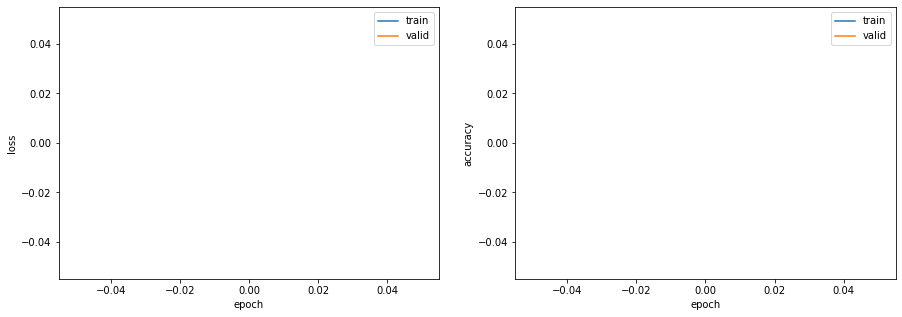

In [ ]:
import matplotlib.pyplot as plt
def visualize_logs():
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(train_loss_log, label='train')
  ax[0].plot(valid_loss_log, label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(train_acc_log, label='train')
  ax[1].plot(valid_acc_log, label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()
visualize_logs()

83

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from torch.nn.utils.rnn import pad_sequence

def padsequence(batch):
  #Dataloaderからミニバッチを取り出すごとに最大系列長でパディング
    sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)
    sequences = [x[0] for x in sorted_batch]
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=PADDING_IDX)
    labels = torch.LongTensor([x[1] for x in sorted_batch])

    return sequences_padded,labels

In [ ]:
def calculate_loss_and_accuracy(model, criterion, dataloader, device):
  """損失・正解率を計算"""
  loss = 0
  with torch.no_grad():
      acc_list = []
      for batch in dataloader:
        x, t = batch
        # デバイスの指定
        x = x.to(device)
        t = t.to(device)

        # 順伝播
        outputs = model(x)

        # 損失計算
        loss += criterion(outputs, t).item()

        # 正解率計算
        pred = torch.argmax(outputs, dim=-1)
        acc = (pred == t).sum() * 1.0 / len(t)
        acc_list.append(acc)

  return loss / len(dataloader), torch.tensor(acc_list).mean()

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(id_word_dic.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(id_word_dic.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50


# モデルの定義
model = MyRNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model = model.to(device)

max_epoch=1
train_loss_log, train_acc_log = [], [] 
valid_loss_log, valid_acc_log = [], [] 

for batch_size in [2,4,6,8,10]:
    train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=padsequence)
    valid_loader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, collate_fn=padsequence)
    for epoch in range(max_epoch):
        for batch in train_loader:
            x, t = batch  # バッチサイズ分のサンプルを抽出
            x = x.to(device)
            t = t.to(device)

            optimizer.zero_grad()   # 勾配を初期化
            # 順伝播
            y = model(x) 
            loss = criterion(y, t)
            # 誤差逆伝播
            loss.backward()
            optimizer.step() 

        # 学習データの損失、正解率を確認
        train_loss, train_acc = calculate_loss_and_accuracy(model, criterion, train_loader, device)
        # 検証データの損失、正解率を確認
        valid_loss, valid_acc = calculate_loss_and_accuracy(model, criterion, valid_loader, device)
        print("batch_size: %d   epoch: %d    train_loss: %.3f   train_acc: %.3f   valid_loss: %.3f   valid_acc: %.3f" % (batch_size, epoch+1, train_loss, train_acc, valid_loss, valid_acc))

        # 進捗状況の保存
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        valid_loss_log.append(valid_loss)
        valid_acc_log.append(valid_acc)

84

In [ ]:
! pip install gensim==4.0.1

import gensim
gensim.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


'4.0.1'

In [ ]:
# 学習済み単語ベクトルのダウンロード
FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt

--2022-08-24 16:20:05--  https://docs.google.com/uc?export=download&confirm=&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving docs.google.com (docs.google.com)... 142.251.107.113, 142.251.107.139, 142.251.107.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.107.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors-     [ <=>                ]   2.33K  --.-KB/s    in 0s      

2022-08-24 16:20:05 (23.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [2386]



In [ ]:
from gensim.models import KeyedVectors

vector = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz", binary=True)

In [ ]:
import numpy as np

# 学習済み単語ベクトルの取得
VOCAB_SIZE = len(set(id_word_dic.values())) + 1
EMB_SIZE = 300
weights = np.zeros((VOCAB_SIZE, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(id_word_dic.keys()):
  try:
    weights[i] = vector[word]
    words_in_pretrained += 1
  except KeyError:
    weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE,))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained} / {VOCAB_SIZE}')
print(weights.size())

学習済みベクトル利用単語数: 8295 / 10306
torch.Size([10306, 300])


In [ ]:
class MyRNN(nn.Module):
  def __init__(self, vocab_size, emb_size, hidden_size, num_layers, output_size, padding_idx, bidirectional, device, emb_weights=None):
    super().__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_directions = bidirectional + 1  # 単方向：1、双方向：2
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, num_layers, bidirectional=bidirectional, batch_first=True)
    self.fc = nn.Linear(hidden_size * self.num_directions, output_size)

  def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden() 
        output, h = self.rnn(self.emb(x), hidden)
        output = self.fc(output[:, -1, :])
        return output

  def init_hidden(self):
    hidden = torch.zeros(self.num_layers * self.num_directions, self.batch_size, self.hidden_size).to(self.device)
    return hidden

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(id_word_dic.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(id_word_dic.values()))
num_layers=1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
bidirectional = False
print(device)

# モデルの定義
model = MyRNN(VOCAB_SIZE, EMB_SIZE, HIDDEN_SIZE, num_layers, OUTPUT_SIZE, PADDING_IDX, bidirectional, device, emb_weights=weights)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

max_epoch=1
train_loss_log, train_acc_log = [], [] 
valid_loss_log, valid_acc_log = [], [] 
for epoch in range(max_epoch):
    for batch in train_loader:
        x, t = batch  # バッチサイズ分のサンプルを抽出
        optimizer.zero_grad()   # 勾配を初期化

        # 順伝播
        y = model(x) 
        loss = criterion(y, t)
        # 誤差逆伝播
        loss.backward()
        optimizer.step() 

    # 学習データの損失、正解率を確認
    train_loss, train_acc = calculate_loss_and_accuracy(model, criterion, train_loader, device)
    # 検証データの損失、正解率を確認
    valid_loss, valid_acc = calculate_loss_and_accuracy(model, criterion, valid_loader, device)
    print("epoch: %d    train_loss: %.3f   train_acc: %.3f   valid_loss: %.3f   valid_acc: %.3f" % (epoch+1, train_loss, train_acc, valid_loss, valid_acc))

    # 進捗状況の保存
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)
    valid_loss_log.append(valid_loss)
    valid_acc_log.append(valid_acc)

cpu
epoch: 1    train_loss: 0.979   train_acc: 0.643   valid_loss: 1.009   valid_acc: 0.635


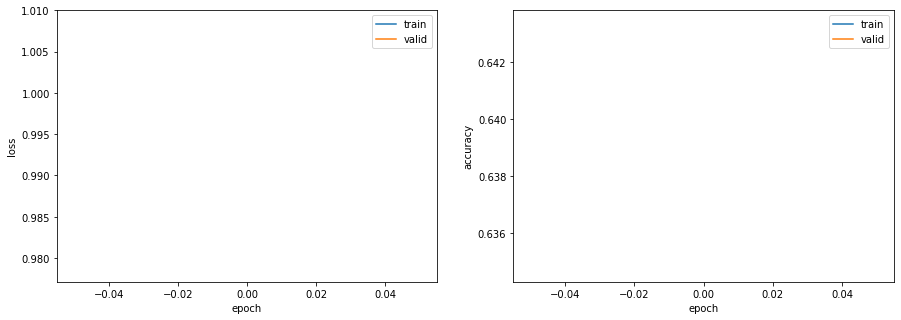

In [ ]:
import matplotlib.pyplot as plt
def visualize_logs():
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(train_loss_log, label='train')
  ax[0].plot(valid_loss_log, label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(train_acc_log, label='train')
  ax[1].plot(valid_acc_log, label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()
visualize_logs()

85. 双方向RNN・多層化

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(id_word_dic.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(id_word_dic.values()))
num_layers=1
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
bidirectional = True
print(device)

# モデルの定義
model = MyRNN(VOCAB_SIZE, EMB_SIZE, HIDDEN_SIZE, num_layers, OUTPUT_SIZE, PADDING_IDX, bidirectional, device, emb_weights=weights)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

max_epoch=1
train_loss_log, train_acc_log = [], [] 
valid_loss_log, valid_acc_log = [], [] 
for epoch in range(max_epoch):
    for batch in train_loader:
        x, t = batch  # バッチサイズ分のサンプルを抽出
        optimizer.zero_grad()   # 勾配を初期化

        # 順伝播
        y = model(x) 
        loss = criterion(y, t)
        # 誤差逆伝播
        loss.backward()
        optimizer.step() 

    # 学習データの損失、正解率を確認
    train_loss, train_acc = calculate_loss_and_accuracy(model, criterion, train_loader, device)
    # 検証データの損失、正解率を確認
    valid_loss, valid_acc = calculate_loss_and_accuracy(model, criterion, valid_loader, device)
    print("epoch: %d    train_loss: %.3f   train_acc: %.3f   valid_loss: %.3f   valid_acc: %.3f" % (epoch+1, train_loss, train_acc, valid_loss, valid_acc))

    # 進捗状況の保存
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)
    valid_loss_log.append(valid_loss)
    valid_acc_log.append(valid_acc)

cpu
epoch: 1    train_loss: 0.912   train_acc: 0.667   valid_loss: 0.971   valid_acc: 0.635


86

In [ ]:
from torch.nn import functional as F

class MyCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, kernel_heights, stride, padding, emb_weights=None):
    super().__init__()
    if emb_weights != None:  # 指定があれば埋め込み層の重みをemb_weightsで初期化
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, (padding, 0))
    self.drop = nn.Dropout(0.3)
    self.fc = nn.Linear(out_channels, output_size)

  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = self.conv(emb)
    # conv.size() = (batch_size, out_channels, seq_len, 1)
    act = F.relu(conv.squeeze(3))
    # act.size() = (batch_size, out_channels, seq_len)
    max_pool = F.max_pool1d(act, act.size()[2])
    # max_pool.size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    out = self.fc(self.drop(max_pool.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(id_word_dic.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(id_word_dic.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = MyCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i][0]
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2586, 0.2016, 0.2231, 0.3166]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2354, 0.2531, 0.2349, 0.2766]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2430, 0.2149, 0.2223, 0.3197]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1922, 0.2413, 0.2252, 0.3413]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2166, 0.2546, 0.2294, 0.2994]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2274, 0.2574, 0.2024, 0.3127]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2391, 0.2813, 0.2025, 0.2771]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2571, 0.2559, 0.2241, 0.2629]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2494, 0.2862, 0.1735, 0.2909]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2198, 0.2234, 0.2339, 0.3229]], grad_fn=<SoftmaxBackward0>)


87

In [ ]:
# パラメータの設定
VOCAB_SIZE = len(set(id_word_dic.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(id_word_dic.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = 100
KERNEL_HEIGHTS = 3
STRIDE = 1
PADDING = 1

# モデルの定義
model = MyCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

max_epoch=1
train_loss_log, train_acc_log = [], [] 
valid_loss_log, valid_acc_log = [], [] 
for epoch in range(max_epoch):
    for batch in train_loader:
        x, t = batch  # バッチサイズ分のサンプルを抽出
        optimizer.zero_grad()   # 勾配を初期化

        # 順伝播
        y = model(x) 
        loss = criterion(y, t)
        # 誤差逆伝播
        loss.backward()
        optimizer.step() 

    # 学習データの損失、正解率を確認
    train_loss, train_acc = calculate_loss_and_accuracy(model, criterion, train_loader, device)
    # 検証データの損失、正解率を確認
    valid_loss, valid_acc = calculate_loss_and_accuracy(model, criterion, valid_loader, device)
    print("epoch: %d    train_loss: %.3f   train_acc: %.3f   valid_loss: %.3f   valid_acc: %.3f" % (epoch+1, train_loss, train_acc, valid_loss, valid_acc))

    # 進捗状況の保存
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)
    valid_loss_log.append(valid_loss)
    valid_acc_log.append(valid_acc)

cpu
epoch: 1    train_loss: 0.740   train_acc: 0.725   valid_loss: 0.874   valid_acc: 0.678


88

In [ ]:
def objective(trial):
    # チューニング対象パラメータのセット
    emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
    out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
    drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
    momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
    batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

    # 固定パラメータの設定
    VOCAB_SIZE = len(set(id_word_dic.values())) + 1
    PADDING_IDX = len(set(id_word_dic.values()))
    OUTPUT_SIZE = 4
    CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
    NUM_EPOCHS = 30

    # モデルの定義
    model = MyCNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, KERNEL_HEIGHTS, STRIDE, PADDING, emb_weights=weights)

    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()

    # オプティマイザの定義
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # デバイスの指定
    device = torch.device('cuda')

    # モデルの学習
    max_epoch=1
    for epoch in range(max_epoch):
        for batch in train_loader:
            x, t = batch  # バッチサイズ分のサンプルを抽出
            optimizer.zero_grad()   # 勾配を初期化

            # 順伝播
            y = model(x) 
            loss = criterion(y, t)
            # 誤差逆伝播
            loss.backward()
            optimizer.step() 

        # 学習データの損失、正解率を確認
        train_loss, train_acc = calculate_loss_and_accuracy(model, criterion, train_loader, device)
        # 検証データの損失、正解率を確認
        valid_loss, valid_acc = calculate_loss_and_accuracy(model, criterion, valid_loader, device)
        print("epoch: %d    train_loss: %.3f   train_acc: %.3f   valid_loss: %.3f   valid_acc: %.3f" % (epoch+1, train_loss, train_acc, valid_loss, valid_acc))

        # 進捗状況の保存
        train_loss_log.append(train_loss)
        train_acc_log.append(train_acc)
        valid_loss_log.append(valid_loss)
        valid_acc_log.append(valid_acc)

  # 損失の算出
        valid_loss, valid_acc = calculate_loss_and_accuracy(model, criterion, valid_loader, device)
    return valid_loss

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 209 kB 38.1 MB/s 
     |████████████████████████████████| 78 kB 3.7 MB/s 
     |████████████████████████████████| 49 kB 6.6 MB/s 
     |████████████████████████████████| 112 kB 57.2 MB/s 
     |████████████████████████████████| 147 kB 60.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=23682d31ca71a9db587f9a10e7e84ee44eb290cd7d2d7ab4cd0ff9d72d340d63
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna

para=optuna.create_study()
para.optimize(objective, n_trials=5)
best = para.best_trial
print(best)

[I 2022-08-24 16:22:48,458] A new study created in memory with name: no-name-01dbe0ab-a1e5-4604-a023-cfae74621ec3
[W 2022-08-24 16:23:05,772] Trial 0 failed because of the following error: RuntimeError('No CUDA GPUs are available')
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-30-64025ec19850>", line 44, in objective
    train_loss, train_acc = calculate_loss_and_accuracy(model, criterion, train_loader, device)
  File "<ipython-input-32-74265d89aad4>", line 9, in calculate_loss_and_accuracy
    x = x.to(device)
  File "/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py", line 217, in _lazy_init
    torch._C._cuda_init()
RuntimeError: No CUDA GPUs are available


RuntimeError: ignored

89

In [ ]:
# ====================
# ライブラリのインストール
# ====================

! pip install transformers==4.5.0
! pip install fugashi==1.1.0
! pip install ipadic==1.0.0
! pip install pytorch-lightning==1.2.7

import glob
import random
from tqdm import tqdm

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer
from transformers import BertForSequenceClassification

In [ ]:
# ====================
# 前処理：データ形式の整理
# ====================

label2id = {"b":0, "t":1, "e":2, "m":3} 

model_name = "cl-tohoku/bert-base-japanese-whole-word-masking"

# 単語分割器の読み込み
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)

# 最大文長さの設定
max_length = 128

def make_dataset(tokenizer, max_length, fname):
    dataset_for_loader = list()
    
    fin = open(fname, "r")
    for line in fin:
        # ラベルとテキストを読み込み
        label, text = line.strip().split("\t")

        # テキストをトークンに分割する。ただし、最大文長は "max_length" で指定したトークン数である。
        # 最大文長より短い文については、 "[PAD]" などの特殊トークンで残りの長さを埋める。
        # 最大文長を超える文については、はみ出す部分を無視する。
        encoding = tokenizer(text, max_length=max_length, padding="max_length", truncation=True)

        # tokenizerメソッドは辞書を返す。その辞書にラベルのIDも持たせる。
        encoding["labels"] = label2id[label]

        # テンソルに変換
        encoding = {key: torch.tensor(value) for key, value in encoding.items()}

        # 前処理済みのデータを保存して次の文へ
        dataset_for_loader.append(encoding)
    fin.close()

    return dataset_for_loader

dataset_train = make_dataset(tokenizer, max_length, fname_train)
dataset_val = make_dataset(tokenizer, max_length, fname_val)
dataset_test = make_dataset(tokenizer, max_length, fname_test)

# データローダを作成。訓練用データはシャッフルしながら使う。
# 検証用と評価用は損失の勾配を計算する必要がないため、バッチサイズを大きめにとれる。
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=256, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=256, shuffle=False)

In [ ]:
# ====================
# BERTによるテキスト分類
# ====================

class Bert4Classification(pl.LightningModule):

    # モデルの読み込みなど。損失関数は自動的に設定される。
    # num_labels == 1 -> 回帰タスクなので MSELoss()
    # num_labels > 1 -> 分類タスクなので CrossEntropyLoss()
    def __init__(self, model_name, num_labels, lr):
        super().__init__()
        self.save_hyperparameters()    # num_labelsとlrを保存する。例えば、self.hparams.lrでlrにアクセスできる。
        self.bert_sc = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    # 訓練用データのバッチを受け取って損失を計算
    def training_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        loss = output.loss
        self.log("train_loss", loss)
        return loss

    # 検証用データのバッチを受け取って損失を計算
    def validation_step(self, batch, batch_idx):
        output = self.bert_sc(**batch)
        val_loss = output.loss
        self.log("val_loss", val_loss)

    # 評価用データのバッチを受け取って分類の正解率を計算
    def test_step(self, batch, batch_idx):
        # ラベルの推定
        output = self.bert_sc(**batch)
        labels_predicted = output.logits.argmax(-1)
        # 正解率の計算
        labels = batch.pop("labels")
        num_correct = (labels_predicted == labels).sum().item()
        accuracy = num_correct / labels.size(0)
        self.log("accuracy", accuracy)

    # 最適化手法を設定
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
# ====================
# 訓練
# ====================

model = Bert4Classification(model_name, num_labels=len(label2id), lr=1e-5)

# 訓練中にモデルを保存するための設定
checkpoint = pl.callbacks.ModelCheckpoint(
    # 検証用データにおける損失が最も小さいモデルを保存する
    monitor="val_loss", mode="min", save_top_k=1,
    # モデルファイル（重みのみ）を "model" というディレクトリに保存する
    save_weights_only=True, dirpath="model/"
)

# 訓練
trainer = pl.Trainer(gpus=1, max_epochs=3, callbacks=[checkpoint])
trainer.fit(model, dataloader_train, dataloader_val)

# ベストモデルの確認
print("ベストモデル: ", checkpoint.best_model_path)
print("ベストモデルの検証用データにおける損失: ", checkpoint.best_model_score)

In [ ]:
# ====================
# 評価
# ====================

test = trainer.test(test_dataloaders=dataloader_test)
print("Test accuracy = %.3f" % (test[0]["accuracy"]))